# Report 2: Theft Over Open Data (TOOD)

> This file is intended to be used as references for sections 3 - 5 which all involves model training, 
> testing, and deployment of the model. Creativity and innovation are encouraged for this and other 
> sections moving forward.

**What is the purpose of this file?**

This notebook will be covering parts 3-5 of the assignment namely going over the following:
1. Predictive Model Building - Building the Predictive Model using Modules within `sklearn`.
2. Model Scoring and Evaluation - Evaluation and Scoring of the Model with Training Data.
3. Model Deployment - Deployment of the model as `.pkl` files.

**NOTE**: The naming of this notebook is intentionally, as it stands for the following:
- `c309` - This is the course code COMP309.
- `r2` - This is the report number which is report 2 of the group project.
- `toodu` - This is the name of the dataset we named and will continue working with in this notebook.
- `model` - This is just a generic name but this notebook will contain sections 3 - 5 which all involves model training, testing, and deployment of the model.

**NOTE**: Provided below is a notebook that includes the above sections, thoroughly covering all aspects of sections 3-5. When required, there will be additional informaiton and insights throughout the notebook to help understand the specifics of the model, algorithms used, and how we handle imbalanced data when training the model.

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DEFAULT_DATA_PATH = os.path.join(os.pardir, "data")

toodu_ft_df = pd.read_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Open_Data_Cleaned.csv"))

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

theft_over_categories = {
    "Theft - Misapprop Funds Over",
    "Theft Over - Bicycle",
    "Theft Over - Distraction",
    "Theft Over",
    "Theft Over - Shoplifting",
    "Theft Of Utilities Over",
    "Theft From Mail / Bag / Key"
}

toodu_ft_df["OFFENCE"] = toodu_ft_df["OFFENCE"].replace(theft_over_categories, "Theft Over")

le = LabelEncoder()
toodu_ft_df["OFFENCE_ENCODED"] = le.fit_transform(toodu_ft_df["OFFENCE"])

categorical_features = [
    "PREMISES_TYPE",
    "LOCATION_TYPE"
]
label_encoders = {}

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    toodu_ft_df[col] = label_encoders[col].fit_transform(toodu_ft_df[col])

In [5]:
features_filtered = toodu_ft_df[categorical_features]
features_filtered

,PREMISES_TYPE,LOCATION_TYPE
0,1,17
1,5,33
2,1,17
3,0,0
4,1,17
...,...,...
13951,4,18
13952,1,17
13953,5,24
13954,0,0


In [6]:
target_filtered = toodu_ft_df["OFFENCE_ENCODED"]
target_filtered

0        1
1        1
2        1
3        1
4        1
        ..
13951    1
13952    1
13953    0
13954    1
13955    1
Name: OFFENCE_ENCODED, Length: 13956, dtype: int32

In [9]:
scaler = StandardScaler()

numerical_features_sf = scaler.fit_transform(features_filtered)
numerical_features_sf

array([[-0.72412973, -0.11482834],
       [ 1.35806962,  1.22334337],
       [-0.72412973, -0.11482834],
       ...,
       [ 1.35806962,  0.47062179],
       [-1.24467957, -1.53663577],
       [ 0.83751978,  0.72152898]])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

x_train, x_test, y_train, y_test = train_test_split(numerical_features_sf, target_filtered, test_size=0.2, random_state=42)

In [11]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# NOTE: We can use a better `sampling_strategy` than just "auto"
smote = SMOTE(random_state=42, sampling_strategy="auto")
x_train, y_train = smote.fit_resample(x_train, y_train)

In [13]:
SAMPLES_PER_CLASS = 1500

unique_classes = np.unique(y_train).tolist()
sampling_strategy = {cls: min(SAMPLES_PER_CLASS, (y_train == cls).sum()) for cls in unique_classes}

under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)

In [16]:
# NOTE: Start of Model Creating and Training

# NOTE: Also can add the following: n_jobs=5, C=100 | C=0.01
model = LogisticRegression(solver="liblinear", random_state=42)
model.fit(x_train, y_train)

score_model = lambda model, x_test, y_test: model.score(x_test, y_test)
score_model(model, x_test, y_test)

0.7707736389684814

In [48]:
# NOTE: Start of Model Scoring and Evaluation (Classification Reports)
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:10]
y_pred_inverse = le.inverse_transform(y_pred)
y_test_inverse = le.inverse_transform(y_test)

print(f"Classification Report: {classification_report(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Training Data Score: {model.score(x_train, y_train)}")
print(f"Testing Data Score (Overall Accuracy): {model.score(x_test, y_test)}")

Classification Report:               precision    recall  f1-score   support

           0       0.53      0.68      0.60       700
           1       0.88      0.80      0.84      2092

    accuracy                           0.77      2792
   macro avg       0.71      0.74      0.72      2792
weighted avg       0.80      0.77      0.78      2792

Accuracy Score: 0.7707736389684814
Training Data Score: 0.739
Testing Data Score (Overall Accuracy): 0.7707736389684814


In [49]:
y_test.value_counts()

OFFENCE_ENCODED
1    2092
0     700
Name: count, dtype: int64

In [50]:
y_pred_proba

array([[0.25824655, 0.74175345],
       [0.21030188, 0.78969812],
       [0.21030188, 0.78969812],
       [0.24253091, 0.75746909],
       [0.79397944, 0.20602056],
       [0.21030188, 0.78969812],
       [0.21030188, 0.78969812],
       [0.45521018, 0.54478982],
       [0.14985842, 0.85014158],
       [0.76822739, 0.23177261]])

In [51]:
null_accuracy_score = (2092/(2092 + 700))
print(f"Null Accuracy Score: {null_accuracy_score}")

Null Accuracy Score: 0.7492836676217765


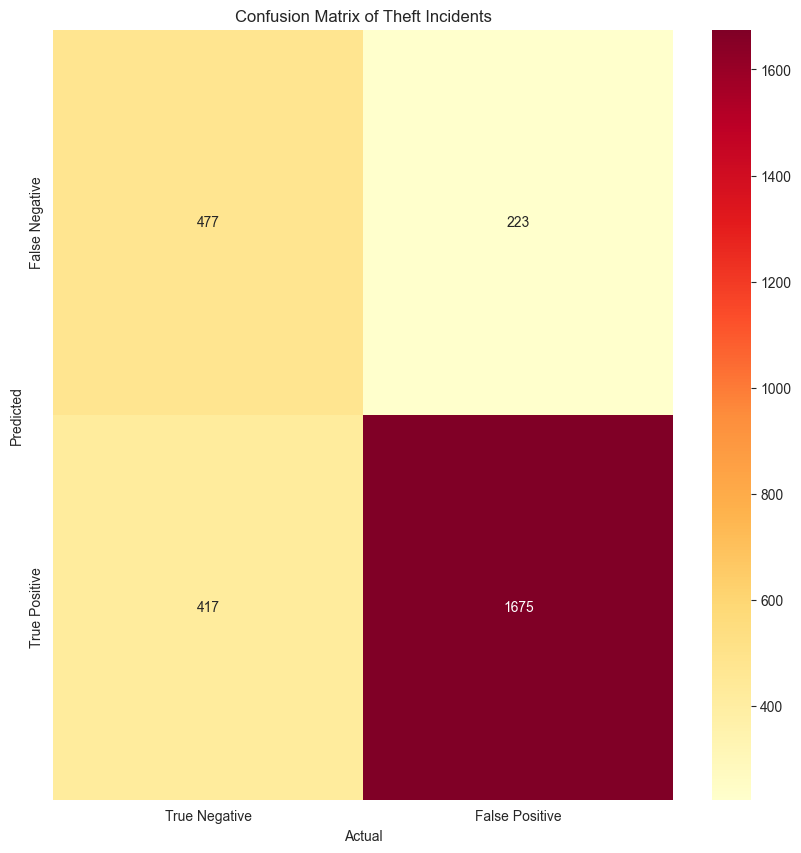

In [52]:
# NOTE: Start of Confusion Matrix and Visualizations

from sklearn.metrics import confusion_matrix

# TODO: FIX THE LABELS!
cm = confusion_matrix(y_test, y_pred)
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="YlOrRd", fmt="d")
plt.title("Confusion Matrix of Theft Incidents")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xticks([0.5, 1.5], labels[:2],rotation=0)
plt.yticks([0.5, 1.5], labels[2:],rotation=90)
plt.show()

In [53]:
# NOTE: Classification Accuracy and Error
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
precision_score = TP / float(TP + FP)
recall_score = TP / float(TP + FN)
true_positive_rate = TP / float(TP + FN)
false_positive_rate = FP / float(FP + TN)

print(f"""
Classification Accuracy: {classification_accuracy}
Classification Error:    {classification_error}
Precision Score:         {precision_score}
Recall Score:            {recall_score}
True Positive Rate:      {true_positive_rate}
False Positive Rate:     {false_positive_rate}
""")


Classification Accuracy: 0.7707736389684814
Classification Error:    0.22922636103151864
Precision Score:         0.6814285714285714
Recall Score:            0.5335570469798657
True Positive Rate:      0.5335570469798657
False Positive Rate:     0.11749209694415173



In [55]:
# TODO: ROC (Receiver Operation Characteristics) Curve Here.

In [56]:
# TODO: Feature Importances Here.

In [26]:
toodu_ft_df.to_csv(os.path.join(DEFAULT_DATA_PATH, "Theft_Over_Data_Cleaned_Encoded.csv"), index=False)